In [1]:
# 1. Importaciones y configuración inicial
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import pyreadstat

pd.set_option('display.max_rows', None)

In [2]:
# 2. Definición de constantes y configuraciones
EMPLOYMENT_STATUS = {
    "Employed, absent from work": 1,
    "Employed, at work": 1
}

INDUSTRY_CATEGORIES = {
    0: "Accommodation and food services",
    1: "Agriculture",
    2: "Business, building and other support services",
    3: "Construction",
    4: "Educational services",
    5: "Finance and insurance",
    6: "Fishing, hunting and trapping",
    7: "Forestry and logging and support activities for forestry",
    8: "Health care and social assistance",
    9: "Information, culture and recreation",
    10: "Manufacturing - durable goods",
    11: "Manufacturing - non-durable goods",
    12: "Mining, quarrying, and oil and gas extraction",
    13: "Other services (except public administration)",
    14: "Professional, scientific and technical services",
    15: "Public administration",
    16: "Real estate and rental and leasing",
    17: "Retail trade",
    18: "Transportation and warehousing",
    19: "Utilities",
    20: "Wholesale trade"
}

NOC_CATEGORIES={
    0: "Business, finance and administration occupations, except management",
    1: "Health occupations, except management",
    2: "Management occupations",
    3: "Natural and applied sciences and related occupations, except management",
    4: "Natural resources, agriculture and related production occupations, except management",
    5: "Occupations in art, culture, recreation and sport, except management",
    6: "Occupations in education, law and social, community and government services, except management",
    7: "Occupations in manufacturing and utilities, except management",
    8: "Sales and service occupations, except management",
    9: "Trades, transport and equipment operators and related occupations, except management",
}

In [3]:
# 3. Funciones de utilidad
def calculate_quality_metrics(df):
    """Calcula porcentajes de zeros y NaN en el dataset"""
    zero_pct = (df == 0).mean() * 100
    nan_pct = df.isna().mean() * 100
    return zero_pct, nan_pct

def encode_categorical_vars(df, columns):
    """Codifica variables categóricas preservando NaN"""
    df_encoded = df.copy()
    
    for col in columns:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
        if col == 'NOC_10':
            df_encoded.loc[df_encoded[col] == -1, col] = np.nan
            
    return df_encoded

# Suponiendo que tu DataFrame se llama df y la columna es SURVMNTH
def get_quarter(month):
    if month in ['January', 'February', 'March']:
        return 'Q1'
    elif month in ['April', 'May', 'June']:
        return 'Q2'
    elif month in ['July', 'August', 'September']:
        return 'Q3'
    elif month in ['October', 'November', 'December']:
        return 'Q4'
    else:
        return None

In [7]:
# 4. Carga y preparación inicial de datos
# Carga de datos
path=r"C:\Users\wmate\Downloads\SPSS\Compilado\2022.sav"
raw_data = pd.read_spss(path)

In [13]:
raw_data.shape

(1306571, 60)

In [10]:
df = raw_data.copy()
df['Quarter'] = df['SURVMNTH'].apply(get_quarter)
df.head(1)

,REC_NUM,SURVYEAR,SURVMNTH,LFSSTAT,PROV,CMA,AGE_12,AGE_6,SEX,MARSTAT,...,LKANSADS,LKOTHERN,PRIORACT,YNOLOOK,TLOLOOK,SCHOOLN,EFAMTYPE,AGYOWNK,FINALWT,Quarter
0,1.0,2022.0,April,Not in labour force,Prince Edward Island,Other CMA or non-CMA,35 to 39 years,NaN,Female,Married,...,NaN,NaN,NaN,NaN,NaN,Non-student,"Single-earner couple, male employed, youngest ...",Youngest child less than 6 years,58.0,Q2


In [14]:

# Variables de interés
variables = ["Has_a_job", "LFSSTAT", "PROV", "AGE_12", "SEX", 
            "MARSTAT", "EDUC", "IMMIG","NOC_10"]
categorical_cols = ["SEX", "MARSTAT", "EDUC","NOC_10"]
feature_cols = ["SEX", "MARSTAT", "EDUC"]

In [15]:
# 5. Creación de variables
# Flag de empleo
df['Has_a_job'] = df['LFSSTAT'].map(lambda x: EMPLOYMENT_STATUS.get(x, 0))

# 6. Preparación para imputación KNN
df_knn = encode_categorical_vars(df[categorical_cols], categorical_cols)

In [16]:
# 7. Imputación KNN para NOC_10
# Preparar datos para KNN
X = df_knn[feature_cols]
X_train = X[df_knn['NOC_10'].notna()]
y_train = df_knn['NOC_10'].dropna()
X_pred = X[df_knn['NOC_10'].isna()]

# Entrenar y predecir
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = np.clip(
    np.round(knn.predict(X_pred)).astype(int),
    0, 9  # Asegura que las predicciones estén en el rango válido
)

# Aplicar predicciones
df_knn.loc[df_knn['NOC_10'].isna(), 'NOC_10'] = y_pred

In [17]:
# 8. Agregar categorías de industria
df_knn['NOC_Category'] = pd.Categorical(df_knn['NOC_10'].map(NOC_CATEGORIES))

# 9. Crear dataset final
df_final = pd.concat([
    df_knn[["NOC_Category"]],
    df[variables],df["Quarter"]
], axis=1)

# 10. Calcular y mostrar métricas de calidad
zero_pct, nan_pct = calculate_quality_metrics(df_final)
print("\nPorcentaje de 0 en cada columna:\n", zero_pct)
print("\nPorcentaje de NaN en cada columna:\n", nan_pct)
print("\nTypo de datos:\n", df_final.dtypes)


Porcentaje de 0 en cada columna:
 NOC_Category     0.000000
Has_a_job       40.996624
LFSSTAT          0.000000
PROV             0.000000
AGE_12           0.000000
SEX              0.000000
MARSTAT          0.000000
EDUC             0.000000
IMMIG            0.000000
NOC_10           0.000000
Quarter          0.000000
dtype: float64

Porcentaje de NaN en cada columna:
 NOC_Category     0.000000
Has_a_job        0.000000
LFSSTAT          0.000000
PROV             0.000000
AGE_12           0.000000
SEX              0.000000
MARSTAT          0.000000
EDUC             0.000000
IMMIG            0.000000
NOC_10          34.600416
Quarter          0.000000
dtype: float64

Typo de datos:
 NOC_Category    category
Has_a_job          int64
LFSSTAT         category
PROV            category
AGE_12          category
SEX             category
MARSTAT         category
EDUC            category
IMMIG           category
NOC_10          category
Quarter           object
dtype: object


# EDA

In [ ]:
# Combine categories and codes into a DataFrame for better readability
category_codes = pd.DataFrame({
    'Category': df['NOC_10'].cat.categories,
    'Code': range(len(df['NOC_10'].cat.categories))
})
print(category_codes)

In [ ]:
df['NOC_10'].cat.categories

In [ ]:
df_final.columns

# Sin Valores NaN

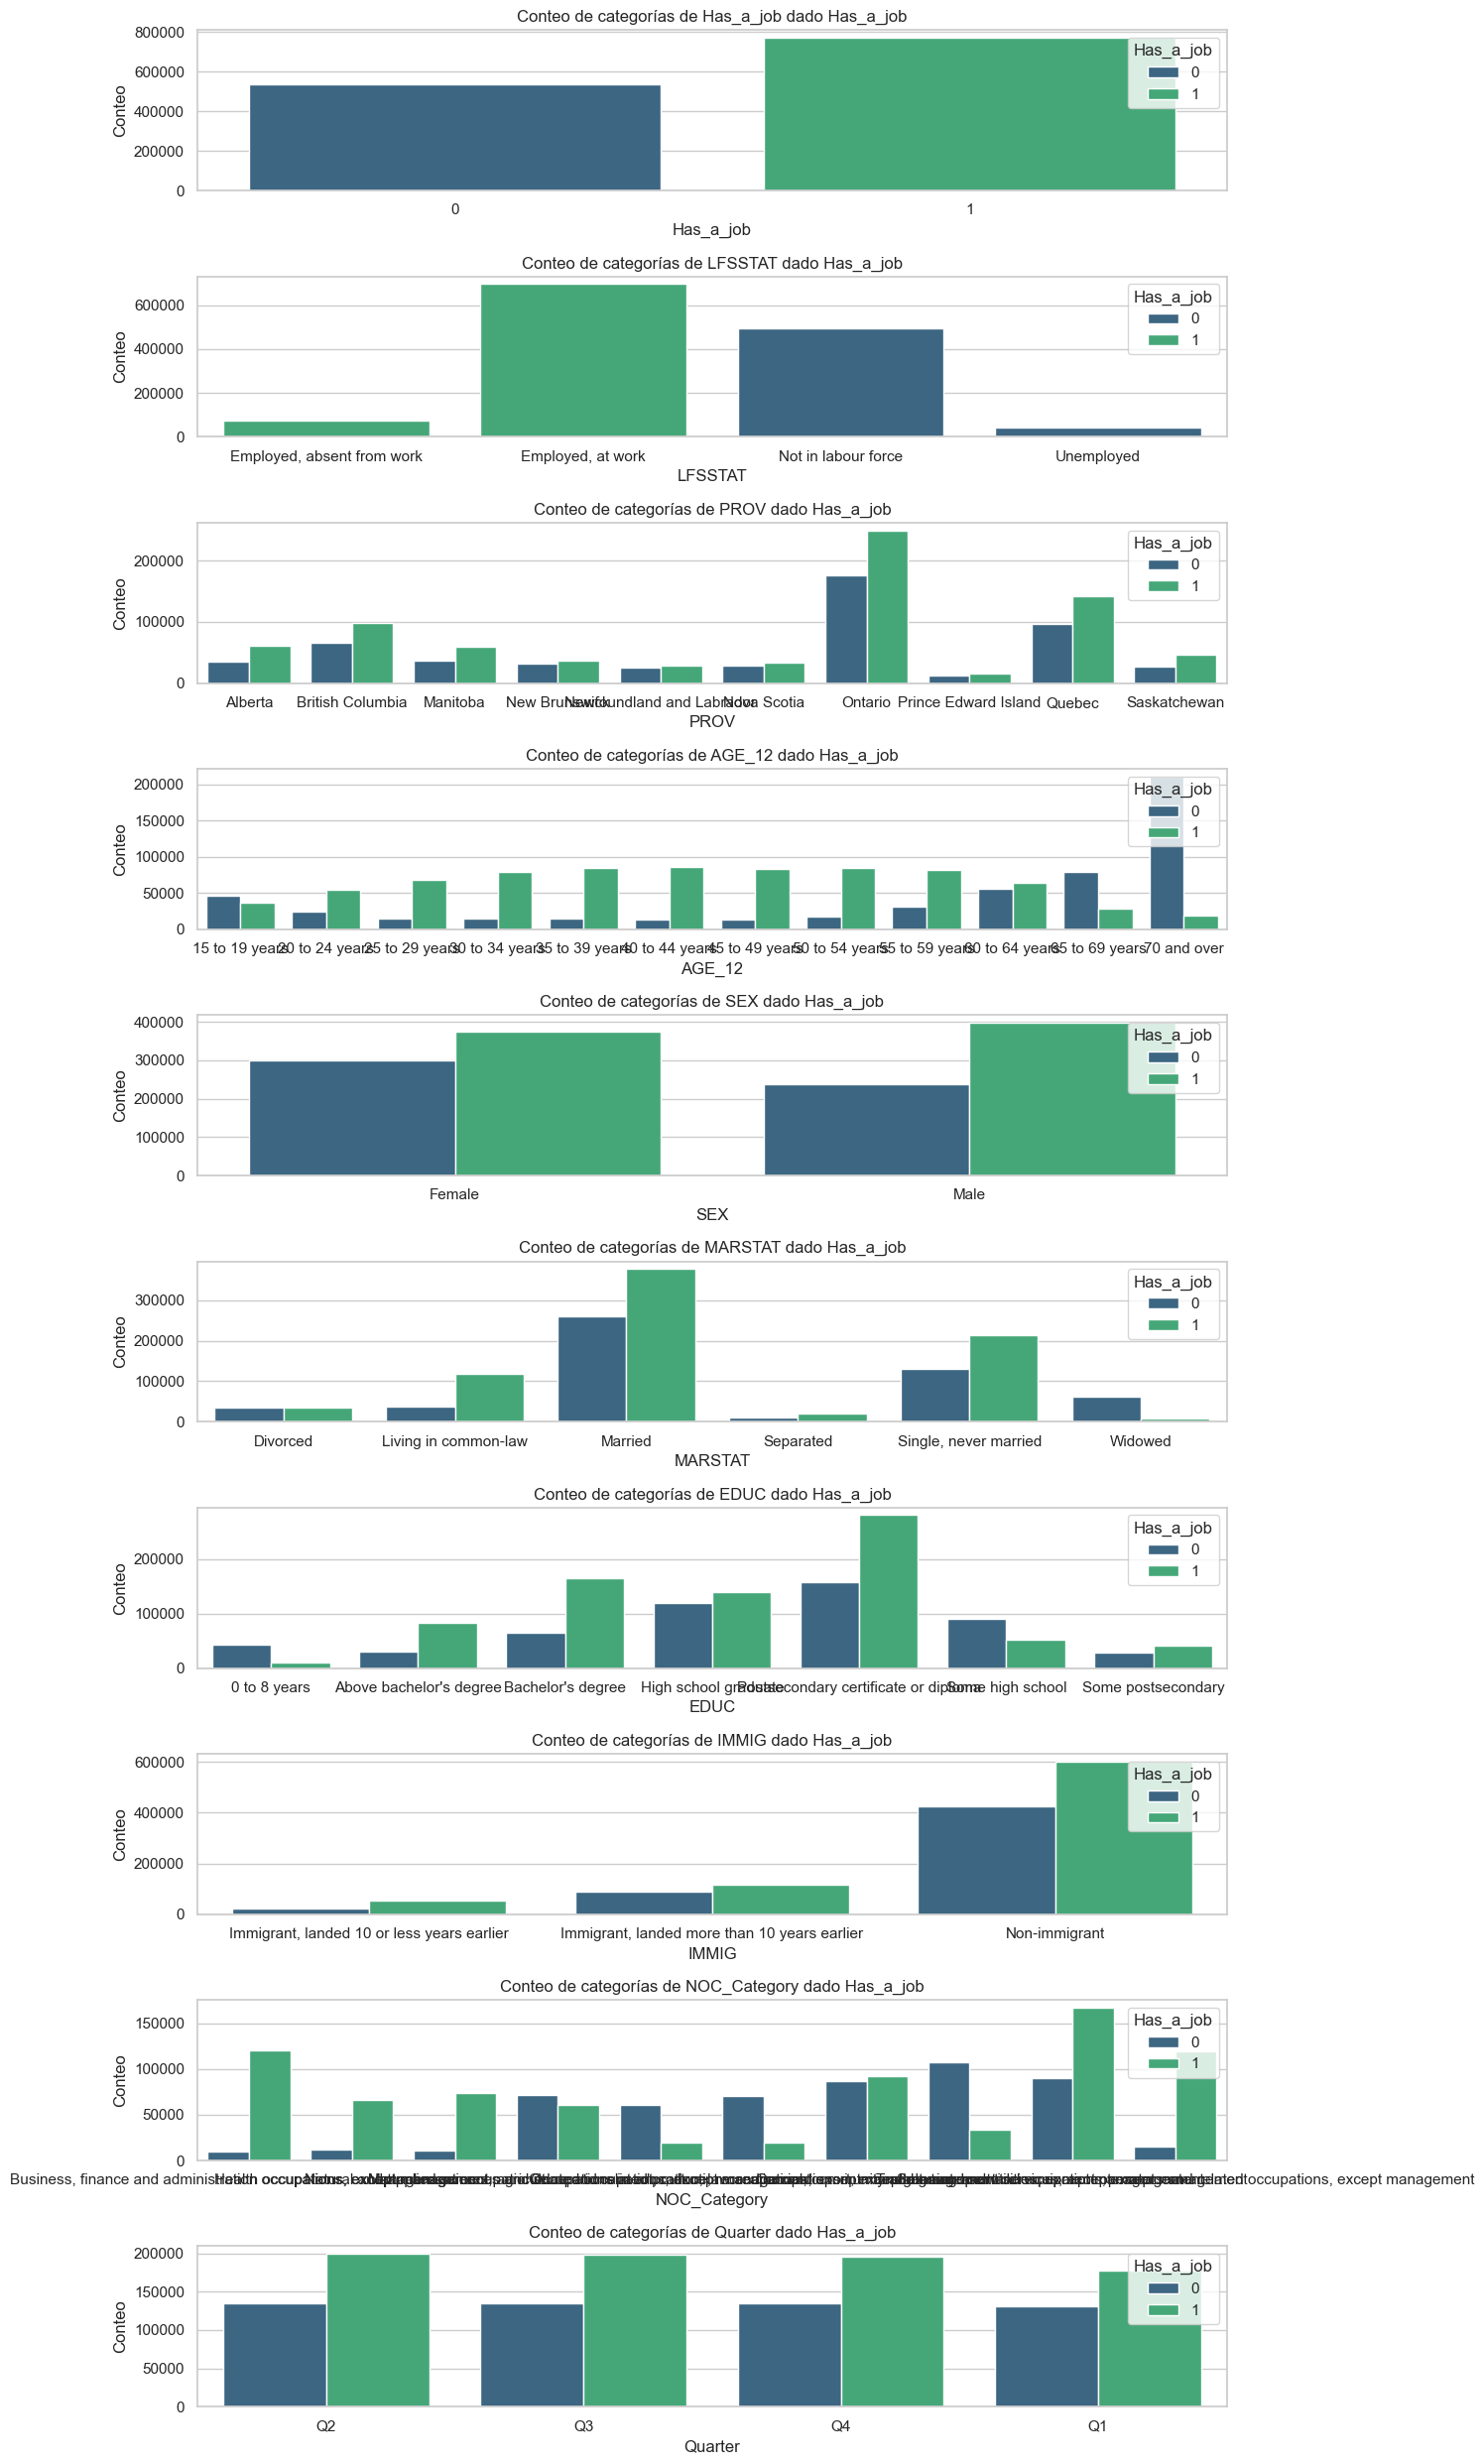

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables de interés
variables_grafico = ["Has_a_job", "LFSSTAT", "PROV", "AGE_12", "SEX", 
            "MARSTAT", "EDUC", "IMMIG", "NOC_Category","Quarter"]

# Ajuste del tamaño del gráfico y estilo
plt.figure(figsize=(15, 25))
sns.set(style="whitegrid")

# Loop para crear un gráfico de barras para cada variable
for i, var in enumerate(variables_grafico, 1):
    plt.subplot(len(variables_grafico), 1, i)
    sns.countplot(data=df_final, x=var, hue="Has_a_job", palette="viridis")
    plt.title(f'Conteo de categorías de {var} dado Has_a_job')
    plt.xlabel(var)
    plt.ylabel("Conteo")
    plt.legend(title="Has_a_job", loc="upper right")

# Ajuste de diseño y despliegue del gráfico
plt.tight_layout()
plt.show()

In [ ]:

pd.crosstab(df_final['NOC_Category'], df_final['Has_a_job'],dropna=False, margins=True, margins_name="Total")

# Con Valores NaN

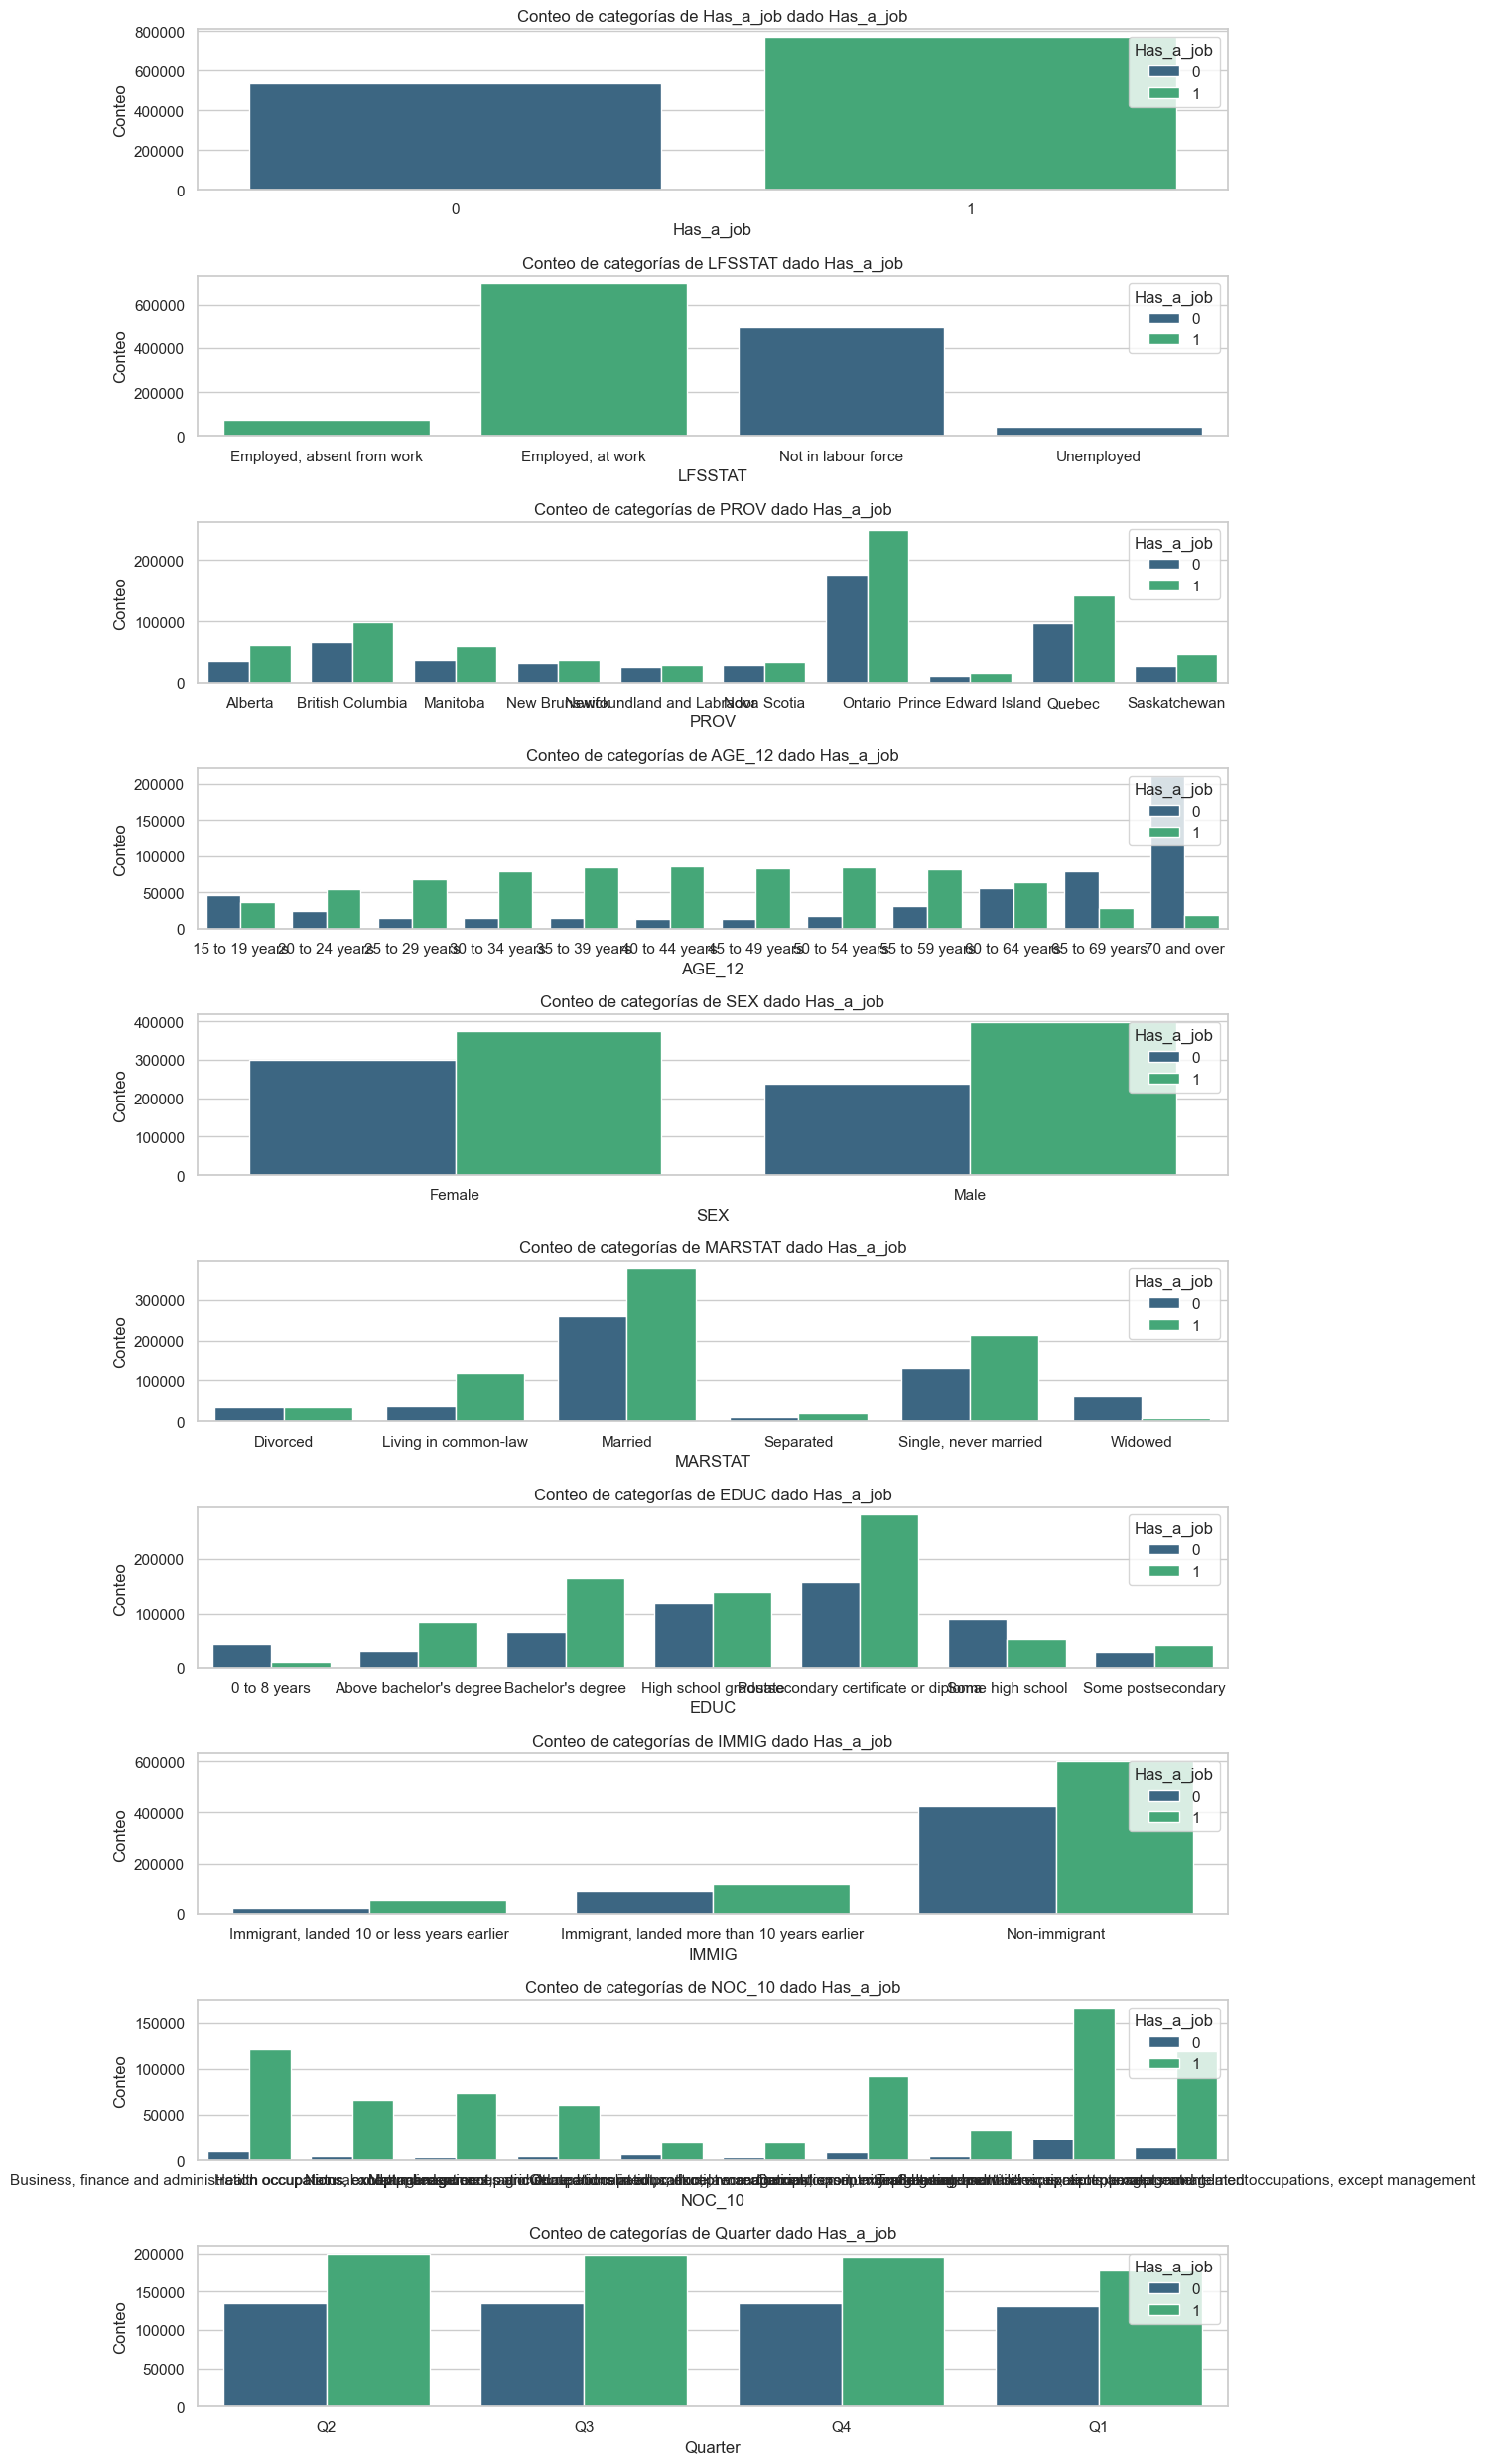

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables de interés
variables_grafico_NaN = ["Has_a_job", "LFSSTAT", "PROV", "AGE_12", "SEX", 
            "MARSTAT", "EDUC", "IMMIG","NOC_10","Quarter"]

# Ajuste del tamaño del gráfico y estilo
plt.figure(figsize=(15, 25))
sns.set(style="whitegrid")

# Loop para crear un gráfico de barras para cada variable
for i, var in enumerate(variables_grafico_NaN, 1):
    plt.subplot(len(variables_grafico_NaN), 1, i)
    sns.countplot(data=df, x=var, hue="Has_a_job", palette="viridis")
    plt.title(f'Conteo de categorías de {var} dado Has_a_job')
    plt.xlabel(var)
    plt.ylabel("Conteo")
    plt.legend(title="Has_a_job", loc="upper right")

# Ajuste de diseño y despliegue del gráfico
plt.tight_layout()
plt.show()

In [ ]:
pd.crosstab(df['NOC_10'], df['Has_a_job'],dropna=False, margins=True, margins_name="Total")

# Logit

In [27]:
df_final["MARSTAT"].unique()

['Married', 'Divorced', 'Single, never married', 'Living in common-law', 'Widowed', 'Separated']
Categories (6, object): ['Divorced', 'Living in common-law', 'Married', 'Separated', 'Single, never married', 'Widowed']

In [28]:
from statsmodels.formula.api import ols, logit

md_logit = logit("Has_a_job ~ C(PROV, Treatment(reference='Newfoundland and Labrador')) + C(AGE_12, Treatment(reference='15 to 19 years'))  + C(SEX, Treatment(reference='Female'))  +  C(MARSTAT, Treatment(reference='Separated'))  + C(EDUC, Treatment(reference='0 to 8 years'))  + C(IMMIG, Treatment(reference='Non-immigrant')) + C(NOC_Category, Treatment(reference='Occupations in art, culture, recreation and sport, except management')) +C(Quarter, Treatment(reference='Q1'))", data=df_final)

res_logit = md_logit.fit()
print(res_logit.summary())

Optimization terminated successfully.
         Current function value: 0.374071
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Has_a_job   No. Observations:              1306571
Model:                          Logit   Df Residuals:                  1306524
Method:                           MLE   Df Model:                           46
Date:                Sun, 03 Nov 2024   Pseudo R-squ.:                  0.4473
Time:                        09:46:21   Log-Likelihood:            -4.8875e+05
converged:                       True   LL-Null:                   -8.8435e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                                                                                                                                                                     coef    std err          z      P>|z|      [0.025    

In [21]:
import pandas as pd
import numpy as np

# Convertimos los odds_ratios a un DataFrame
odds_ratios_df = pd.DataFrame({'Variable': res_logit.params.index, 'Odds_Ratio': np.exp(res_logit.params.values)})

# Extraemos el intercepto y lo removemos del DataFrame para agregarlo manualmente
intercept_odds = odds_ratios_df.loc[odds_ratios_df['Variable'] == 'Intercept', 'Odds_Ratio'].values[0]
intercept_probabilidad = intercept_odds / (1 + intercept_odds)

# Creamos listas para almacenar los resultados
variables = ["Intercepto"]
odds_values = [intercept_odds]
probabilidades = [intercept_probabilidad]

# Iteramos sobre cada nivel de las variables categóricas
for index, row in odds_ratios_df[odds_ratios_df['Variable'] != 'Intercept'].iterrows():
    variable_name = row['Variable']
    odds = intercept_odds * row['Odds_Ratio']  # Calculamos los odds multiplicando por el intercepto
    probabilidad = odds / (1 + odds)           # Convertimos los odds a probabilidad

    # Añadimos los resultados a las listas
    variables.append(variable_name)
    odds_values.append(odds)
    probabilidades.append(probabilidad)

# Creamos el DataFrame final con los resultados, incluyendo el intercepto en la primera fila
probabilidades_df = pd.DataFrame({
    'Variable': variables,
    'Odds': odds_values,
    'Probabilidad': probabilidades
})

probabilidades_df

,Variable,Odds,Probabilidad
0,Intercepto,2.742938,0.732830
1,C(PROV)[T.British Columbia],2.616014,0.723452
2,C(PROV)[T.Manitoba],2.893333,0.743151
3,C(PROV)[T.New Brunswick],2.207146,0.688196
4,C(PROV)[T.Newfoundland and Labrador],1.901239,0.655320
5,C(PROV)[T.Nova Scotia],2.153694,0.682912
6,C(PROV)[T.Ontario],2.395788,0.705518
7,C(PROV)[T.Prince Edward Island],2.662422,0.726957
8,C(PROV)[T.Quebec],2.848279,0.740144
9,C(PROV)[T.Saskatchewan],2.880627,0.742310


# Export to csv

In [22]:
# Mostramos el DataFrame de probabilidades
year=path.split("\\")[-1].split(".")[0]
probabilidades_df.to_csv(f"Probabilidades_{year}.csv")


# OLS

In [ ]:
from statsmodels.formula.api import ols, logit

mod = ols("HRLYEARN ~ C(EDUC, Treatment(reference='0 to 8 years'))+ C(AGE_12)+C(IMMIG)+C(NAICS_21)+C(SEX)+C(PROV)+C(UNION)+C(COWMAIN)", data=df)
res = mod.fit()
print(res.summary())

In [ ]:

mod = ols("HRLYEARN ~C(EDUC)*C(IMMIG, Treatment(reference='Non-immigrant')) + C(AGE_12)  +  C(SEX) ", data=df)
res = mod.fit(cov_type='HC2')
print(res.summary())

# Final